In [1]:
import sys
sys.version

'3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import time
import os
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [119]:
colors = {
#     "black": 1,
#     "red": 5,
    "green": 3,
#     "yellow": 4,
    "blue": 2,
#     "nothing": 0,
#     "white": 6
}

In [120]:
y = pd.DataFrame()
y["col"] = []
read_in_cols = []
for i, (k, v) in enumerate(colors.items()):
    read_in_cols.append(pd.read_csv(f"input/{k}.rtf"))
    read_in_cols[i]["col"] = [v] * len(read_in_cols[i])
    
colors_dataset = pd.concat(read_in_cols)

colors_dataset.head()

,r,g,b,h,s,v,col
0,63,91,72,139.2857,0.3077,91,3
1,64,93,73,138.6207,0.3118,93,3
2,59,89,70,142.0000,0.3371,89,3
3,61,91,71,140.0000,0.3297,91,3
4,60,92,72,142.5000,0.3478,92,3


In [70]:
colors_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5582 entries, 0 to 1325
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   r       5582 non-null   int64  
 1    g      5582 non-null   int64  
 2    b      5582 non-null   int64  
 3    h      5582 non-null   float64
 4    s      5582 non-null   float64
 5    v      5582 non-null   int64  
 6   col     5582 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 348.9 KB


In [71]:
import sklearn

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, _tree
from sklearn.metrics import accuracy_score, classification_report

In [121]:
df = colors_dataset
eda_df = df.copy()

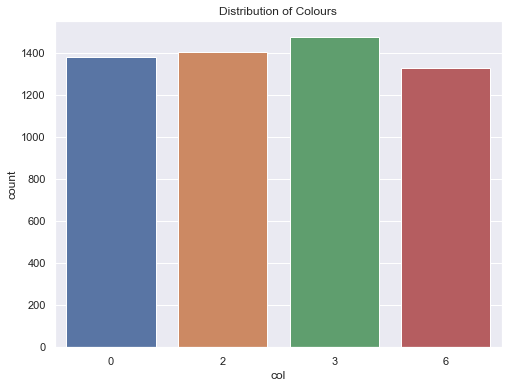

In [75]:
sns.set()

# Distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='col', data=eda_df)
plt.title('Distribution of Colours')
plt.show()

In [122]:
X = df.drop(columns=["r", " g", " b", "col"])
# X = df.drop(columns=[" h", " s", " v", "col"])
# X = df.drop(columns=["col"])
y = df["col"]

In [123]:
X["vs"] = [v*s for v, s in zip(X[" v"], X[" s"])]

In [124]:
X.head()

,h,s,v,vs
0,139.2857,0.3077,91,28.0007
1,138.6207,0.3118,93,28.9974
2,142.0000,0.3371,89,30.0019
3,140.0000,0.3297,91,30.0027
4,142.5000,0.3478,92,31.9976


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [93]:
def tree_to_array(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    tree_array = [-1]*2**(dtc.get_params()['max_depth']+1)
    def dtc_treeing(node, index):
#         print(node)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            if name ==  "vs":
                extra = 6000
            elif name == "h":
                extra = 7000
            elif name == "s":
                extra = 8000
            elif name == "v":
                extra = 9000
            else:
                extra = 0
            threshold = tree_.threshold[node]
            value = threshold + extra
            tree_array[index] = value
            dtc_treeing(tree_.children_left[node], index*2+1)
            dtc_treeing(tree_.children_right[node], index*2)
        else:
            tree_array[index] = int(class_names[int(tree_.value[node].argmax())]) + 5000
    dtc_treeing(0, 1)
    return tree_array
#     print(f"def tree({', '.join(feature_names)}):")
# tree_ = dtc.tree_

# tree_.value[0].argmax():

In [91]:
def DTC_Compare(node_value, h, s, v):
    vs = v*s
    res = False
    to_compare = 0
    extra = 0
    if node_value >= 6000:
        to_compare = vs
        extra = 6000
    if node_value >= 7000:
        to_compare = h
        extra = 7000
    if node_value >= 8000:
        to_compare = s
        extra = 8000
    if node_value >= 9000:
        to_compare = v
        extra = 9000
    res = to_compare < (node_value-extra)
            
    if node_value >= 5000 and node_value <= 5006:
        return (res, node_value - 5000)
    else:
        return (res, -1)
    
def DTC_Colores(h, s, v):
    position = 1
    while True:
#         print(position)
        node_value = tree_array[position]
        if node_value == 0:
            break
        else:
            (res, col) = DTC_Compare(node_value, h, s, v)
            if col != -1:
                break
#             print(position)
            position = position * 2 + (1 if res else 0)
    return col

In [42]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Classifier
dtc = DecisionTreeClassifier(random_state=42)

# Define the cross-validation strategy (Stratified K-Folds)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object with F1 scoring, stratified k-fold cross-validation, and the parameter grid
grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, scoring='f1_macro', cv=stratified_kfold)

# Perform the grid search on the data
grid_search.fit(X, y)

# Print the best parameters and corresponding F1 score
print("Best Parameters: ", grid_search.best_params_)
print("Best F1 Score: {:.2f}".format(grid_search.best_score_))


Best Parameters:  {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.92


In [138]:
# HT
dtc = DecisionTreeClassifier(**{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5}, random_state=42)

# ## EV3
# dtc = DecisionTreeClassifier(** {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}, random_state=42)

dtc.fit(X_train, y_train)

predictions = dtc.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

print("Classification Report:")
print(classification_report(y_test, predictions))

tree_array = tree_to_array(dtc, ['h', 's', 'v', 'vs'], [2, 3])

st = time.time()

tree_array.append(0)

print(DTC_Colores(60, 0.1294, 255 ) == 6)
print(DTC_Colores(42.2581, 0.7949, 234) == 4)
print(DTC_Colores(4.2857, 0.56, 100 ) == 5)
print(DTC_Colores(240, 0.25, 4) == 0)
print(DTC_Colores(220.5882, 0.8718, 39 ) == 2)
print(DTC_Colores(192, 0.3846, 13) == 3)
print(DTC_Colores(141.5385, 0.4432, 88) == 3)
print(DTC_Colores(200, 0.1364, 22 ) == 1)
print(DTC_Colores(52.1739, 0.1729, 133 ) == 6)
print(DTC_Colores(45.7143, 0.2165, 97 ) == 6)
print(DTC_Colores(47.3684, 0.2184, 87 ) == 6)
print(DTC_Colores(56.8421, 0.2235, 170 ) == 6)
print(DTC_Colores(57.8571, 0.2044, 137 ) == 6)
print(DTC_Colores(64.0909, 0.2222, 198 ) == 6)
print(DTC_Colores(36, 0.1111, 45 ) == 6)
print(DTC_Colores(60, 0.0513, 39 ) == 6)
print(DTC_Colores(153.75, 0.2712, 59 ) == 3)
print(DTC_Colores(142.1053, 0.2676, 71 ) == 3)
print(DTC_Colores(147.1698, 0.8154, 65 ) == 3)
print(DTC_Colores(165, 0.2105, 19) == 3)
print(DTC_Colores(147.5, 0.8, 30 ) == 3)
print(DTC_Colores(147.8571, 0.8235, 34 ) == 3)
print(DTC_Colores(148.2353, 0.7391, 23 ) == 3)
print(DTC_Colores(148.4211, 0.7917, 24 ) == 3)
print(DTC_Colores(200, 0.6, 5 ) == 0)
print(DTC_Colores(240, 0.3333, 3 ) == 0)
print(DTC_Colores(180, 1, 1 ) == 0)
print(DTC_Colores(210, 0.6667, 3 ) == 0)
print(DTC_Colores(180, 0.5, 2 ) == 0)
print(DTC_Colores(195, 0.6667, 6 ) == 0)
print(DTC_Colores(240, 0.3333, 3 ) == 0)

print("test")
print(DTC_Colores(8, 0.88, 76))





et = time.time()

elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Accuracy: 100.00%
Classification Report:
              precision    recall  f1-score   support

           2       1.00      1.00      1.00       265
           3       1.00      1.00      1.00       311

    accuracy                           1.00       576
   macro avg       1.00      1.00      1.00       576
weighted avg       1.00      1.00      1.00       576

False
False
False
False
True
True
True
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
test
3
Execution time: 0.003002643585205078 seconds


In [131]:
print(f"Total Length: {len(tree_array)}")
print(f"'Blank' Nodes: {sum([x == -1 or x == 0 for x in tree_array])}")
print(f"Comparison Nodes: {sum([x >= 6000 for x in tree_array])}")
print(f"Output Nodes: {sum([x < 6000 and x >= 5000 for x in tree_array])}")

Total Length: 8
'Blank' Nodes: 2
Comparison Nodes: 3
Output Nodes: 3


In [139]:
with open('output/dtc_bg.rtf', 'w') as file:
    # Write list elements to the file
    for item in tree_array:
        file.write(str(item) + '\n')  # Writes each item on a new line

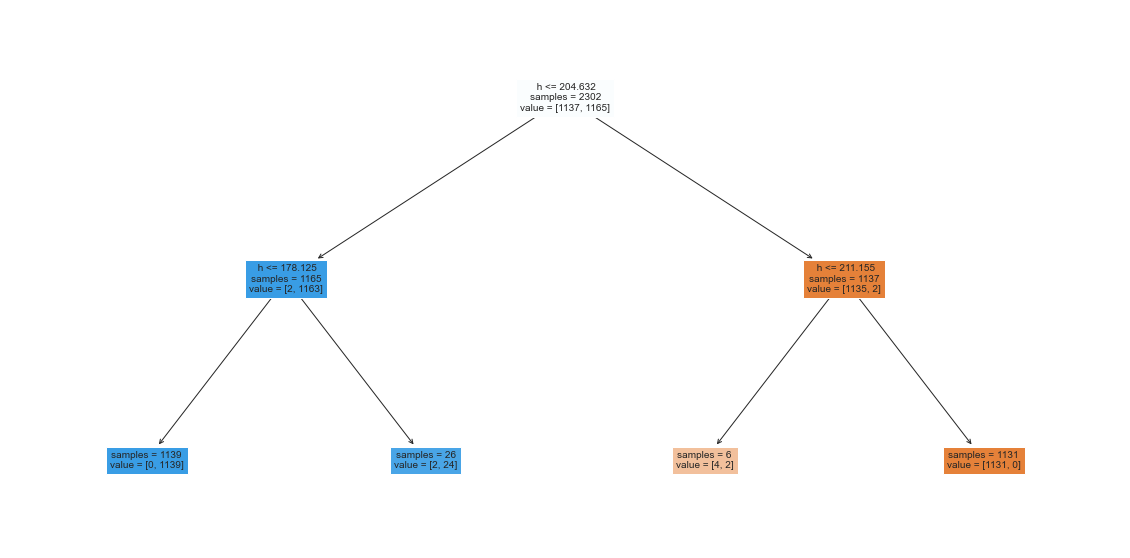

In [140]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    dtc,
    feature_names=X.columns,
    impurity=False,
    filled=True,
    ax=ax,
    fontsize=10,
)
plt.show()